Analysis on F001

          Engine ID         Cycle    OpSetting1    OpSetting2  OpSetting3  \
count  20631.000000  20631.000000  20631.000000  20631.000000     20631.0   
mean      51.506568    108.807862     -0.000009      0.000002       100.0   
std       29.227633     68.880990      0.002187      0.000293         0.0   
min        1.000000      1.000000     -0.008700     -0.000600       100.0   
25%       26.000000     52.000000     -0.001500     -0.000200       100.0   
50%       52.000000    104.000000      0.000000      0.000000       100.0   
75%       77.000000    156.000000      0.001500      0.000300       100.0   
max      100.000000    362.000000      0.008700      0.000600       100.0   

            Sensor1       Sensor2       Sensor3       Sensor4       Sensor5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.3947

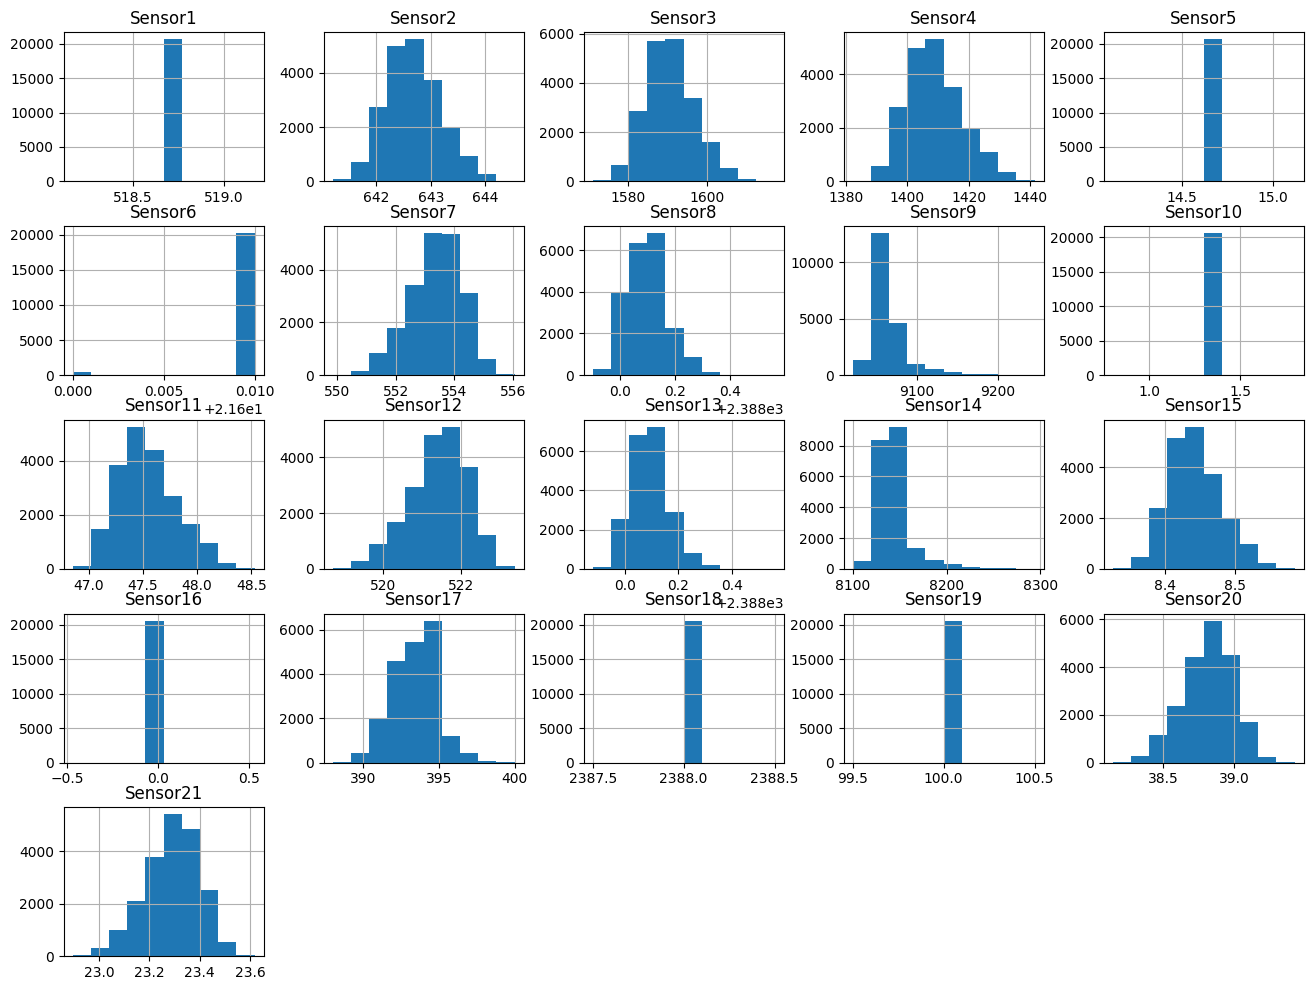

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load train data
train_fd001 = pd.read_csv('/content/train_FD001.txt', sep=" ", header=None)
train_fd001.dropna(axis=1, inplace=True)  # Clean up any extra columns
train_fd001.columns = ['Engine ID', 'Cycle', 'OpSetting1', 'OpSetting2', 'OpSetting3'] + [f'Sensor{i}' for i in range(1, 22)]

# Descriptive statistics
print(train_fd001.describe())

# Plot histograms for sensors
train_fd001[[f'Sensor{i}' for i in range(1, 22)]].hist(figsize=(16, 12))
plt.show()

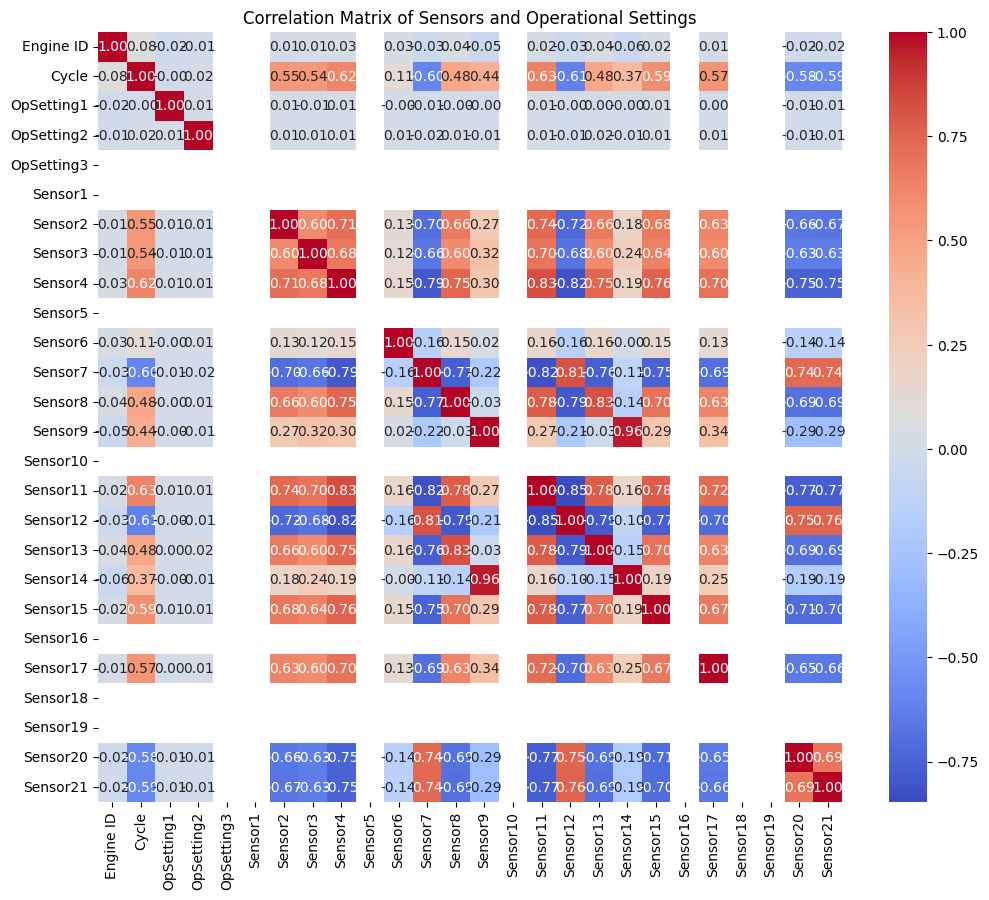

In [ ]:
# Calculate the correlation matrix
correlation_matrix = train_fd001.corr()

# Plot the heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Sensors and Operational Settings')
plt.show()


Model Traning and Validation for F001

In [ ]:
import pandas as pd

# Load the train data
train_data = pd.read_csv('/content/train_FD001.txt', sep=" ", header=None)
train_data.dropna(axis=1, inplace=True)  # Clean up any extra columns
train_data.columns = ['Engine ID', 'Cycle', 'OpSetting1', 'OpSetting2', 'OpSetting3'] + [f'Sensor{i}' for i in range(1, 22)]

# Load the test data
test_data = pd.read_csv('/content/test_FD001.txt', sep=" ", header=None)
test_data.dropna(axis=1, inplace=True)
test_data.columns = ['Engine ID', 'Cycle', 'OpSetting1', 'OpSetting2', 'OpSetting3'] + [f'Sensor{i}' for i in range(1, 22)]

# Load the RUL data
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)
rul_test.columns = ['RUL']  # The actual Remaining Useful Life for the test set

In [ ]:
# Calculate RUL for training data
rul_train = pd.DataFrame(train_data.groupby('Engine ID')['Cycle'].max()).reset_index()
rul_train.columns = ['Engine ID', 'MaxCycle']
train_data = train_data.merge(rul_train, on='Engine ID')
train_data['RUL'] = train_data['MaxCycle'] - train_data['Cycle']
train_data.drop('MaxCycle', axis=1, inplace=True)


In [ ]:
# Drop unnecessary columns
drop_columns = ['Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
X_train = train_data.drop(columns=drop_columns + ['RUL', 'Engine ID', 'Cycle'])
X_test = test_data.drop(columns=drop_columns + ['Engine ID', 'Cycle'])
y_train = train_data['RUL']

In [ ]:
# Create rolling mean
train_data['Sensor1_rolling_mean'] = train_data.groupby('Engine ID')['Sensor1'].rolling(window=5).mean().reset_index(level=0, drop=True)
train_data['Sensor1_diff'] = train_data.groupby('Engine ID')['Sensor1'].diff()


In [ ]:
from sklearn.preprocessing import RobustScaler

# Initialize the robust scaler
scaler = RobustScaler()

# Apply scaling to training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import joblib

feature_columns = X_train.columns
joblib.dump(feature_columns, 'feature_columns.pkl')
# Train the RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
joblib.dump(model, 'random_forest_model_fd001.pkl')

print("Model saved successfully.")


Model saved successfully.


In [ ]:
# Let's say you want to test on a specific engine, e.g., Engine ID = 1
engine_id = 97

# Get the last cycle data for this engine from the test set
test_engine_data = test_data[test_data['Engine ID'] == engine_id]
last_cycle = test_engine_data['Cycle'].max()

# Get the row corresponding to the last cycle of the engine
test_engine_last_cycle = test_engine_data[test_engine_data['Cycle'] == last_cycle]

# Drop unnecessary columns (same as before)
X_test_engine_last_cycle = test_engine_last_cycle.drop(columns=drop_columns + ['Engine ID', 'Cycle'])

# Scale the test data for prediction
X_test_engine_last_cycle_scaled = scaler.transform(X_test_engine_last_cycle)

# Predict the RUL for this engine's last cycle
predicted_rul = model.predict(X_test_engine_last_cycle_scaled)

# Get the actual RUL for this engine from the RUL.txt file
actual_rul = rul_test.iloc[engine_id - 1]['RUL']  # Subtract 1 because engine IDs are 1-based, but DataFrame indexing is 0-based

# Print predicted vs actual RUL
print(f"Engine ID: {engine_id}")
print(f"Predicted RUL: {predicted_rul[0]:.2f}")
print(f"Actual RUL: {actual_rul:.2f}")


Engine ID: 97
Predicted RUL: 75.61
Actual RUL: 82.00


In [ ]:
import pandas as pd

# Create a list to store the results
results = []

# Loop through each engine in the test set
for engine_id in test_data['Engine ID'].unique():
    # Get the last cycle data for this engine
    test_engine_data = test_data[test_data['Engine ID'] == engine_id]
    last_cycle = test_engine_data['Cycle'].max()

    # Get the row corresponding to the last cycle of the engine
    test_engine_last_cycle = test_engine_data[test_engine_data['Cycle'] == last_cycle]

    # Drop unnecessary columns (same as before)
    X_test_engine_last_cycle = test_engine_last_cycle.drop(columns=drop_columns + ['Engine ID', 'Cycle'])

    # Scale the test data for prediction
    X_test_engine_last_cycle_scaled = scaler.transform(X_test_engine_last_cycle)

    # Predict the RUL for this engine's last cycle
    predicted_rul = model.predict(X_test_engine_last_cycle_scaled)[0]

    # Round the predicted RUL to 2 decimal places
    predicted_rul_rounded = round(predicted_rul, 2)

    # Get the actual RUL for this engine from the RUL.txt file
    actual_rul = rul_test.iloc[engine_id - 1]['RUL']  # Subtract 1 because engine IDs are 1-based, but DataFrame indexing is 0-based

    # Store the results in the list with rounded predicted RUL
    results.append([engine_id, predicted_rul_rounded, actual_rul])

    # Print the results for this engine
    print(f"Engine ID: {engine_id}")
    print(f"Predicted RUL: {predicted_rul_rounded:.2f}")
    print(f"Actual RUL: {actual_rul:.2f}")
    print()

# Convert the results into a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Engine ID', 'Predicted RUL', 'Actual RUL'])

# Display the table
print(results_df)


Engine ID: 1
Predicted RUL: 167.05
Actual RUL: 112.00

Engine ID: 2
Predicted RUL: 147.09
Actual RUL: 98.00

Engine ID: 3
Predicted RUL: 57.98
Actual RUL: 69.00

Engine ID: 4
Predicted RUL: 112.84
Actual RUL: 82.00

Engine ID: 5
Predicted RUL: 124.98
Actual RUL: 91.00

Engine ID: 6
Predicted RUL: 117.10
Actual RUL: 93.00

Engine ID: 7
Predicted RUL: 133.10
Actual RUL: 91.00

Engine ID: 8
Predicted RUL: 113.34
Actual RUL: 95.00

Engine ID: 9
Predicted RUL: 125.14
Actual RUL: 111.00

Engine ID: 10
Predicted RUL: 127.71
Actual RUL: 96.00

Engine ID: 11
Predicted RUL: 65.25
Actual RUL: 97.00

Engine ID: 12
Predicted RUL: 94.59
Actual RUL: 124.00

Engine ID: 13
Predicted RUL: 102.31
Actual RUL: 95.00

Engine ID: 14
Predicted RUL: 158.20
Actual RUL: 107.00

Engine ID: 15
Predicted RUL: 187.05
Actual RUL: 83.00

Engine ID: 16
Predicted RUL: 134.89
Actual RUL: 84.00

Engine ID: 17
Predicted RUL: 55.62
Actual RUL: 50.00

Engine ID: 18
Predicted RUL: 70.59
Actual RUL: 28.00

Engine ID: 19
Predic

In [ ]:
# Ensure the predicted RUL column is rounded to 2 decimal places
results_df['Predicted RUL'] = results_df['Predicted RUL'].round(0)

# Display the table with rounded values
print(results_df)


    Engine ID  Predicted RUL  Actual RUL
0           1          167.0         112
1           2          147.0          98
2           3           58.0          69
3           4          113.0          82
4           5          125.0          91
..        ...            ...         ...
95         96          166.0         137
96         97           76.0          82
97         98           90.0          59
98         99          157.0         117
99        100           17.0          20

[100 rows x 3 columns]


In [ ]:
import plotly.graph_objects as go

# Create an interactive plot using Plotly
fig = go.Figure()

# Add the predicted RUL as a line plot
fig.add_trace(go.Scatter(x=results_df['Engine ID'], y=results_df['Predicted RUL'],
                         mode='lines+markers', name='Predicted RUL', marker=dict(symbol='circle')))

# Add the actual RUL as a line plot
fig.add_trace(go.Scatter(x=results_df['Engine ID'], y=results_df['Actual RUL'],
                         mode='lines+markers', name='Actual RUL', marker=dict(symbol='x')))

# Add title and labels
fig.update_layout(
    title="Interactive Plot: Predicted vs Actual RUL for Each Engine",
    xaxis_title="Engine ID",
    yaxis_title="RUL (Cycles)",
    legend_title="RUL Type"
)

# Round Predicted RUL and Actual RUL to 2 decimal places
results_df['Predicted RUL'] = results_df['Predicted RUL'].round(0)
results_df['Actual RUL'] = results_df['Actual RUL'].round(0)

# Calculate the absolute difference (error) between predicted and actual RUL
results_df['Error'] = abs(results_df['Predicted RUL'] - results_df['Actual RUL'])

# Sort by the smallest error and select the top 5 closely predicted values
top_5_closest = results_df.nsmallest(5, 'Error')

# Print the top 5 closely predicted values
print(top_5_closest)

# Display the interactive plot
fig.show()


    Engine ID  Predicted RUL  Actual RUL  Error
31         32           48.0          48    0.0
61         62           54.0          54    0.0
81         82            9.0           9    0.0
23         24           21.0          20    1.0
33         34            6.0           7    1.0


11/26

<ipython-input-1-44c0cd61022c>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('/content/train_FD001.txt', delim_whitespace=True, header=None)
<ipython-input-1-44c0cd61022c>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('/content/test_FD001.txt', delim_whitespace=True, header=None)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 33.605803070303196
MAE: 24.15
    Engine ID  Predicted RUL  Actual RUL
0           1          178.0         112
1           2          147.0          98
2           3           64.0          69
3           4          109.0          82
4           5          124.0          91
..        ...            ...         ...
95         96          162.0         137
96         97           81.0          82
97         98           88.0          59
98         99          167.0         117
99        100           18.0          20

[100 rows x 3 columns]


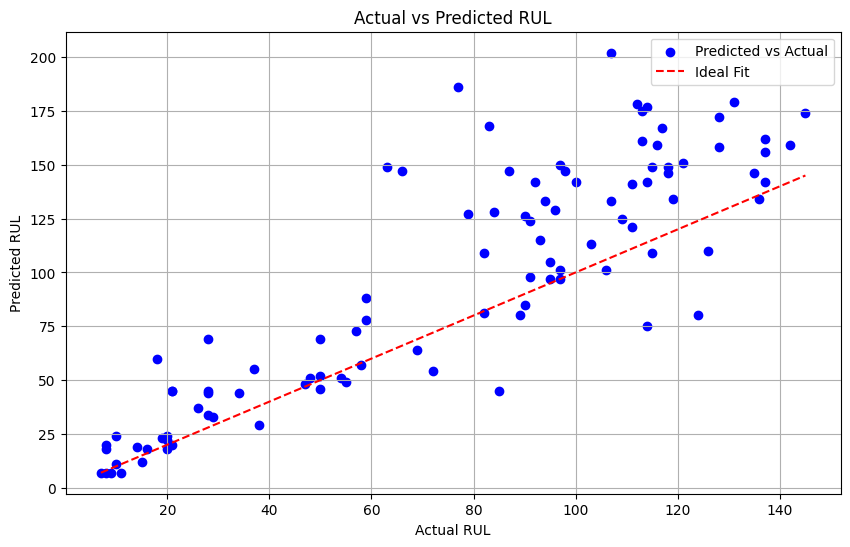

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Load FD001 dataset
train_data = pd.read_csv('/content/train_FD001.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv('/content/test_FD001.txt', delim_whitespace=True, header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Rename columns
column_names = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = column_names
test_data.columns = column_names
rul_test.columns = ['RUL']

# Drop less important features based on correlation matrix
drop_columns = ['Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data = train_data.drop(columns=drop_columns)
test_data = test_data.drop(columns=drop_columns)

# Normalize sensor data
scaler = MinMaxScaler()
sensor_columns = [col for col in train_data.columns if 'Sensor' in col]
train_data[sensor_columns] = scaler.fit_transform(train_data[sensor_columns])
test_data[sensor_columns] = scaler.transform(test_data[sensor_columns])

# Feature Engineering
train_data['Sensor11_diff'] = train_data.groupby('Engine ID')['Sensor11'].diff().fillna(0)
test_data['Sensor11_diff'] = test_data.groupby('Engine ID')['Sensor11'].diff().fillna(0)

train_data['Sensor15_rolling_mean'] = train_data.groupby('Engine ID')['Sensor15'].rolling(window=5).mean().reset_index(level=0, drop=True).fillna(0)
test_data['Sensor15_rolling_mean'] = test_data.groupby('Engine ID')['Sensor15'].rolling(window=5).mean().reset_index(level=0, drop=True).fillna(0)

# Calculate Remaining Useful Life (RUL) for training data
max_cycle = train_data.groupby('Engine ID')['Cycle'].max()
train_data['RUL'] = train_data['Engine ID'].map(max_cycle) - train_data['Cycle']

# Prepare training and testing data
X_train = train_data.drop(columns=['Engine ID', 'Cycle', 'RUL'])
y_train = train_data['RUL']

X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred_rounded, squared=False)
mae = mean_absolute_error(y_test, y_pred_rounded)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Display predictions
results_df = pd.DataFrame({'Engine ID': test_data['Engine ID'].unique(), 'Predicted RUL': y_pred_rounded, 'Actual RUL': y_test})
print(results_df)

# Visualize predictions vs. actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(results_df['Actual RUL'], results_df['Predicted RUL'], c='blue', label='Predicted vs Actual')
plt.plot([results_df['Actual RUL'].min(), results_df['Actual RUL'].max()],
         [results_df['Actual RUL'].min(), results_df['Actual RUL'].max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm  # Progress bar library

# Load FD001 dataset
train_data = pd.read_csv('/content/train_FD001.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv('/content/test_FD001.txt', delim_whitespace=True, header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Assign column names based on dataset description
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Feature Engineering
print("Starting feature engineering...")
for sensor in tqdm(['Sensor11', 'Sensor15'], desc="Feature Engineering"):
    train_data[f'{sensor}_rolling_mean'] = (
        train_data.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
    )
    train_data[f'{sensor}_diff'] = train_data.groupby('Engine ID')[sensor].diff()

# Drop unnecessary columns
drop_columns = ['Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Create RUL column for train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Prepare training data
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']

# Prepare test data
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
X_test_scaled = StandardScaler().fit_transform(X_test)
y_test = rul_test['RUL']

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train-test split for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestRegressor(random_state=42)
print("Starting hyperparameter tuning...")
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=0
)

for _ in tqdm(range(1), desc="Hyperparameter Tuning"):
    grid_search.fit(X_train_split, y_train_split)

# Train the best model
print("Training the best model...")
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_scaled, y_train)

# Save the model
joblib.dump(best_rf, 'random_forest_model_fd001.pkl')

# Evaluate the model on the test set
print("Evaluating the model...")
y_pred = best_rf.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'Test RMSE: {rmse}')
print(f'Test R^2: {r2}')

# Compare predicted vs actual RUL
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.grid()
plt.show()

# Display predictions for all engines
print("Generating predictions...")
results_df = pd.DataFrame({'Engine ID': test_data['Engine ID'].unique(), 'Predicted RUL': y_pred, 'Actual RUL': y_test})
results_df['Predicted RUL'] = results_df['Predicted RUL'].round()
print(results_df)


<ipython-input-2-e83a9da1a671>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('/content/train_FD001.txt', delim_whitespace=True, header=None)
<ipython-input-2-e83a9da1a671>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('/content/test_FD001.txt', delim_whitespace=True, header=None)


Starting feature engineering...


Feature Engineering: 100%|██████████| 2/2 [00:00<00:00, 18.09it/s]

Calculating RUL...
Scaling features...


Starting hyperparameter tuning...


Hyperparameter Tuning: 100%|██████████| 1/1 [44:35<00:00, 2675.75s/it]


Training the best model...
Evaluating the model...


ValueError: X has 18 features, but RandomForestRegressor is expecting 22 features as input.

Loading saved model and preprocessing artifacts...
Loading test data...
Preprocessing test data...
Making predictions...
Evaluating the model...
Test RMSE: 32.80426801500073
Test R^2: 0.3768377183778091


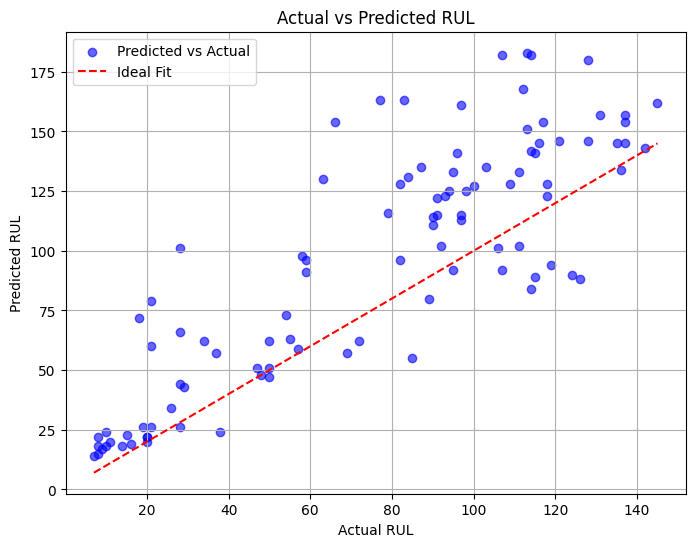


Predictions:
    Engine ID  Predicted RUL  Actual RUL
0           1          168.0         112
1           2          125.0          98
2           3           57.0          69
3           4          128.0          82
4           5          122.0          91
..        ...            ...         ...
95         96          157.0         137
96         97           96.0          82
97         98           96.0          59
98         99          154.0         117
99        100           20.0          20

[100 rows x 3 columns]
Results saved to 'predicted_vs_actual_rul.csv'.


In [ ]:
# Load saved model, scaler, and features
print("Loading saved model and preprocessing artifacts...")
model = joblib.load('/content/random_forest_model_fd001.pkl')
scaler = joblib.load('scaler_fd001.pkl')
features = joblib.load('features_fd001.pkl')  # List of features used during training

# Load test data
print("Loading test data...")
test_data = pd.read_csv('/content/test_FD001.txt', sep='\s+', header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Define column names for test data
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
test_data.columns = columns
rul_test.columns = ['RUL']

# Preprocess test data
print("Preprocessing test data...")
# Add rolling mean and difference features for high-correlation sensors
test_data['Sensor11_rolling_mean'] = test_data.groupby('Engine ID')['Sensor11'].rolling(window=5).mean().reset_index(level=0, drop=True)
test_data['Sensor15_rolling_mean'] = test_data.groupby('Engine ID')['Sensor15'].rolling(window=5).mean().reset_index(level=0, drop=True)
test_data['Sensor11_diff'] = test_data.groupby('Engine ID')['Sensor11'].diff()
test_data['Sensor15_diff'] = test_data.groupby('Engine ID')['Sensor15'].diff()

# Group by Engine ID and select the last cycle for each engine
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])

# Ensure the feature list matches those used during training
X_test = X_test[features]

# Scale test features using the saved scaler
X_test_scaled = scaler.transform(X_test)

# Load actual RUL values
y_test = rul_test['RUL']

# Predict RUL using the saved model
print("Making predictions...")
y_pred = model.predict(X_test_scaled)

# Round predictions for better readability
y_pred = np.round(y_pred)

# Evaluate the predictions
print("Evaluating the model...")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R^2: {r2}")

# Compare predicted vs actual RUL
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.grid()
plt.show()

# Save and display results
results_df = pd.DataFrame({'Engine ID': test_data['Engine ID'].unique(), 'Predicted RUL': y_pred, 'Actual RUL': y_test})
print("\nPredictions:")
print(results_df)
results_df.to_csv('predicted_vs_actual_rul.csv', index=False)
print("Results saved to 'predicted_vs_actual_rul.csv'.")


Loading datasets...
Performing feature engineering on training data...
Performing feature engineering on test data...
Scaling features...
Training the model...
Evaluating the model...
Test RMSE: 32.820143534118834
Test R^2: 0.3762344177000032


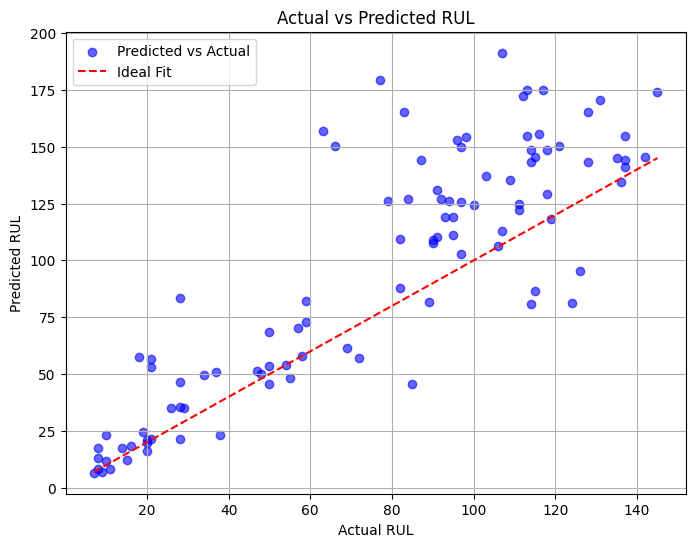


Predictions:
    Engine ID  Predicted RUL  Actual RUL
0           1          172.0         112
1           2          154.0          98
2           3           61.0          69
3           4          109.0          82
4           5          131.0          91
..        ...            ...         ...
95         96          141.0         137
96         97           88.0          82
97         98           82.0          59
98         99          175.0         117
99        100           21.0          20

[100 rows x 3 columns]
Results saved to 'predicted_vs_actual_rul.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

# Load datasets
print("Loading datasets...")
train_data = pd.read_csv('/content/train_FD001.txt', sep='\s+', header=None)
test_data = pd.read_csv('/content/test_FD001.txt', sep='\s+', header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Feature Engineering (Train Dataset)
print("Performing feature engineering on training data...")
for sensor in ['Sensor11', 'Sensor15']:
    train_data[f'{sensor}_rolling_mean'] = train_data.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
    train_data[f'{sensor}_rolling_std'] = train_data.groupby('Engine ID')[sensor].rolling(window=5).std().reset_index(level=0, drop=True)
    train_data[f'{sensor}_diff'] = train_data.groupby('Engine ID')[sensor].diff()

# Feature Engineering (Test Dataset)
print("Performing feature engineering on test data...")
for sensor in ['Sensor11', 'Sensor15']:
    test_data[f'{sensor}_rolling_mean'] = test_data.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
    test_data[f'{sensor}_rolling_std'] = test_data.groupby('Engine ID')[sensor].rolling(window=5).std().reset_index(level=0, drop=True)
    test_data[f'{sensor}_diff'] = test_data.groupby('Engine ID')[sensor].diff()

# Drop unnecessary columns
drop_columns = ['Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Add RUL column to training data
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Prepare training data
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']

# Prepare test data
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])

# Ensure test data has all features used during training
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and features for reuse
joblib.dump(scaler, 'scaler_fd001.pkl')
joblib.dump(features.tolist(), 'features_fd001.pkl')

# Train the model
print("Training the model...")
model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
model.fit(X_train_scaled, y_train)

# Save the model
joblib.dump(model, 'random_forest_model_fd001.pkl')

# Evaluate the model
print("Evaluating the model...")
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(rul_test, y_pred))
r2 = r2_score(rul_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R^2: {r2}")

# Plot Actual vs Predicted RUL
plt.figure(figsize=(8, 6))
plt.scatter(rul_test, y_pred, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([rul_test.min(), rul_test.max()], [rul_test.min(), rul_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.grid()
plt.show()

# Save predictions
results_df = pd.DataFrame({'Engine ID': test_data['Engine ID'].unique(), 'Predicted RUL': y_pred, 'Actual RUL': rul_test['RUL']})
results_df['Predicted RUL'] = results_df['Predicted RUL'].round()
print("\nPredictions:")
print(results_df)
results_df.to_csv('predicted_vs_actual_rul.csv', index=False)
print("Results saved to 'predicted_vs_actual_rul.csv'.")


Loading datasets...
Performing feature engineering...
Calculating RUL...
Scaling features...
Starting hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Training the best model...
Evaluating the model...
Test RMSE: 32.03988854669101
Test R^2: 0.4055402874946594


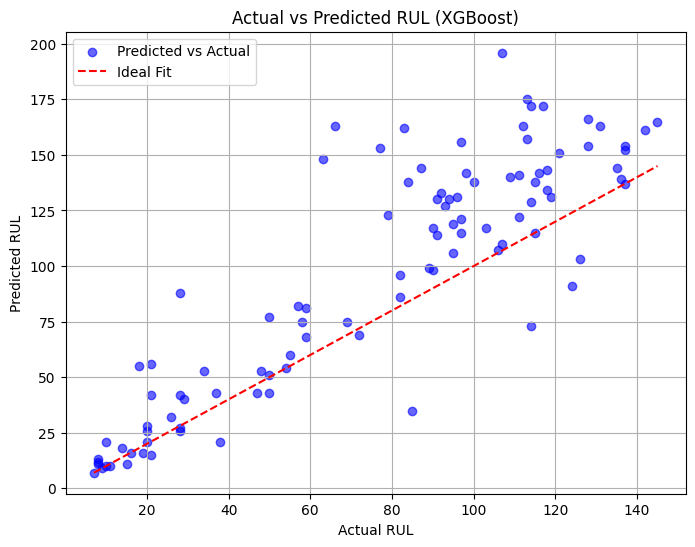

Results saved to 'xgb_predicted_vs_actual_rul.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

# Load FD001 dataset
print("Loading datasets...")
train_data = pd.read_csv('/content/train_FD001.txt', sep='\s+', header=None)
test_data = pd.read_csv('/content/test_FD001.txt', sep='\s+', header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Assign column names based on dataset description
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Feature Engineering
print("Performing feature engineering...")
for dataset in [train_data, test_data]:
    # Add rolling statistics and differences for correlated sensors
    for sensor in ['Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).std().reset_index(level=0, drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby('Engine ID')[sensor].diff()

# Drop unnecessary columns based on correlation matrix analysis
drop_columns = ['Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Add RUL column to train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Prepare training data
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']

# Prepare test data (last cycle for each engine)
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Ensure feature consistency between train and test
features = X_train.columns
X_test = X_test[features]  # Select features used in training

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and features
joblib.dump(scaler, 'scaler_fd001.pkl')
joblib.dump(features.tolist(), 'features_fd001.pkl')

# Hyperparameter Tuning with Cross-Validation (XGBoost)
print("Starting hyperparameter tuning...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Train the best model
print("Training the best model...")
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_scaled, y_train)

# Save the model
joblib.dump(best_xgb, 'xgb_model_fd001.pkl')

# Evaluate the model on the test set
print("Evaluating the model...")
y_pred = best_xgb.predict(X_test_scaled)
y_pred_rounded = np.round(y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R^2: {r2}")

# Visualize results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rounded, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Save predictions to CSV
results_df = pd.DataFrame({'Engine ID': test_data['Engine ID'].unique(), 'Predicted RUL': y_pred_rounded, 'Actual RUL': y_test})
results_df.to_csv('xgb_predicted_vs_actual_rul.csv', index=False)
print("Results saved to 'xgb_predicted_vs_actual_rul.csv'.")


In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


Loading datasets...
Performing feature engineering...
Calculating RUL...
Performing Recursive Feature Elimination (RFE)...


[I 2024-11-27 03:47:07,977] A new study created in memory with name: no-name-1098058f-4d0d-418b-97e4-05a1a6b13495


Scaling features...
Starting Bayesian Optimization...


<ipython-input-15-2f0a9aba0c22>:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-15-2f0a9aba0c22>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
<ipython-input-15-2f0a9aba0c22>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.8, 1.0),
[I 2024-11-27 03:47:09,312] Trial 0 finished with value: 32.67835749173647 and parameters: {'n_estimator

Training the best model...
Evaluating the model...
Test RMSE: 30.722244300340993
Test R^2: 0.45342934131622314


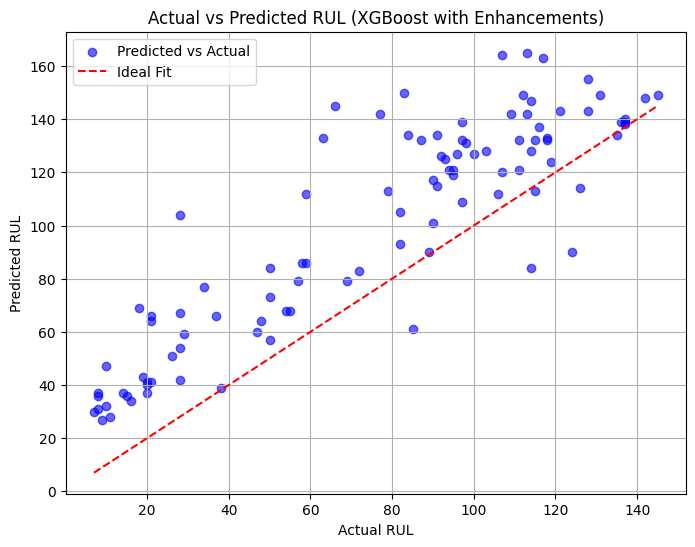

Results saved to 'xgb_predicted_vs_actual_rul.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import xgboost as xgb
import optuna
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
from scipy.signal import savgol_filter

# Load FD001 dataset
print("Loading datasets...")
train_data = pd.read_csv('/content/train_FD001.txt', sep='\s+', header=None)
test_data = pd.read_csv('/content/test_FD001.txt', sep='\s+', header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Assign column names based on dataset description
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Feature Engineering
print("Performing feature engineering...")
for dataset in [train_data, test_data]:
    for sensor in ['Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).std().reset_index(level=0, drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby('Engine ID')[sensor].diff()
        dataset[sensor] = savgol_filter(dataset[sensor], window_length=5, polyorder=2)  # Smoothing

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Add RUL column to train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Prepare training and test data
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Feature Selection with RFE
print("Performing Recursive Feature Elimination (RFE)...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
rfe = RFE(estimator=xgb_model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]

# Use only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and selected features
joblib.dump(scaler, 'scaler_fd001.pkl')
joblib.dump(selected_features.tolist(), 'features_fd001.pkl')

# Bayesian Optimization for Hyperparameter Tuning
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.8, 1.0),
    }
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

print("Starting Bayesian Optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Train the best model
print("Training the best model...")
best_params = study.best_params
best_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
best_xgb.fit(X_train_scaled, y_train)

# Save the model
joblib.dump(best_xgb, 'xgb_model_fd001.pkl')

# Evaluate the model
print("Evaluating the model...")
y_pred = best_xgb.predict(X_test_scaled)
y_pred_rounded = np.round(y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R^2: {r2}")

# Visualize results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rounded, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (XGBoost with Enhancements)')
plt.legend()
plt.grid()
plt.show()

# Save predictions
results_df = pd.DataFrame({'Engine ID': test_data['Engine ID'].unique(), 'Predicted RUL': y_pred_rounded, 'Actual RUL': y_test})
results_df.to_csv('xgb_predicted_vs_actual_rul.csv', index=False)
print("Results saved to 'xgb_predicted_vs_actual_rul.csv'.")


Loading datasets...
Performing feature engineering...
Calculating RUL...
Performing Recursive Feature Elimination (RFE)...


[I 2024-11-27 04:16:39,590] A new study created in memory with name: no-name-ade1672f-8286-477a-8407-f3d283b893d5


Scaling features...
Starting Bayesian Optimization...


<ipython-input-20-269704e3a1e9>:84: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-20-269704e3a1e9>:85: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
<ipython-input-20-269704e3a1e9>:86: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.8, 1.0),
[I 2024-11-27 04:16:40,054] Trial 0 finished with value: 555.9449414343798 and parameters: {'n_estimator

Training the best model...
Evaluating the model...
Test RMSE: 30.723419719363786
Test R^2: 0.4533874988555908


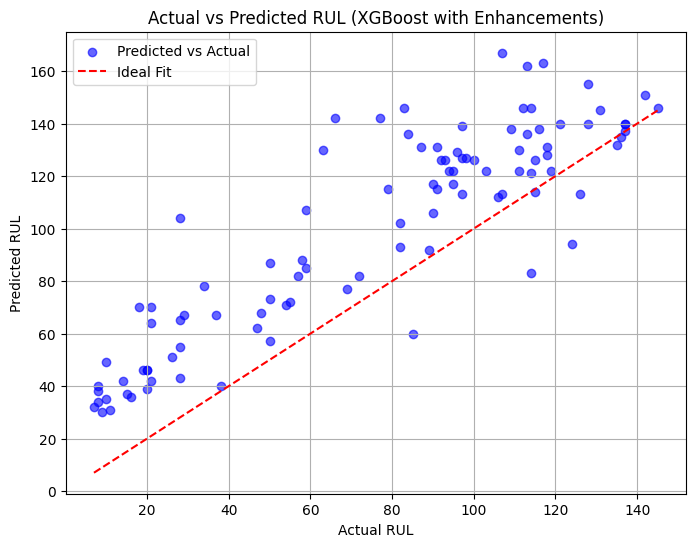

Results saved to 'xgb_predicted_vs_actual_rul.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import xgboost as xgb
import optuna
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
from scipy.signal import savgol_filter

# Load FD001 dataset
print("Loading datasets...")
train_data = pd.read_csv('/content/train_FD001.txt', sep='\s+', header=None)
test_data = pd.read_csv('/content/test_FD001.txt', sep='\s+', header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Assign column names based on dataset description
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Feature Engineering
print("Performing feature engineering...")
for dataset in [train_data, test_data]:
    for sensor in ['Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).std().reset_index(level=0, drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby('Engine ID')[sensor].diff()
        dataset[sensor] = savgol_filter(dataset[sensor], window_length=5, polyorder=2)  # Smoothing

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Add RUL column to train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Prepare training and test data
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Feature Selection with RFE
print("Performing Recursive Feature Elimination (RFE)...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
rfe = RFE(estimator=xgb_model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]

# Use only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and selected features
joblib.dump(scaler, 'scaler_fd001.pkl')
joblib.dump(selected_features.tolist(), 'features_fd001.pkl')

# Define a custom loss function for penalizing large RUL errors
def custom_loss(y_true, y_pred):
    error = y_true - y_pred
    return np.mean(np.where(error > 0, error**2, 0.5 * error**2))  # Penalize underpredictions more

# Bayesian Optimization for Hyperparameter Tuning
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.8, 1.0),
    }
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    return custom_loss(y_test, preds)

print("Starting Bayesian Optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Train the best model
print("Training the best model...")
best_params = study.best_params
best_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
best_xgb.fit(X_train_scaled, y_train)

# Save the model
joblib.dump(best_xgb, 'xgb_model_fd001.pkl')

# Evaluate the model
print("Evaluating the model...")
y_pred = best_xgb.predict(X_test_scaled)
y_pred_rounded = np.round(y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R^2: {r2}")

# Visualize results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rounded, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (XGBoost with Enhancements)')
plt.legend()
plt.grid()
plt.show()

# Save predictions
results_df = pd.DataFrame({'Engine ID': test_data['Engine ID'].unique(), 'Predicted RUL': y_pred_rounded, 'Actual RUL': y_test})
results_df.to_csv('xgb_predicted_vs_actual_rul.csv', index=False)
print("Results saved to 'xgb_predicted_vs_actual_rul.csv'.")


In [ ]:
# Create a DataFrame with predicted vs actual values
results_df = pd.DataFrame({
    'Engine ID': test_data['Engine ID'].unique(),
    'Predicted RUL': y_pred,
    'Actual RUL': y_test
})

# Round the predicted RUL for better readability
results_df['Predicted RUL'] = results_df['Predicted RUL'].round()

# Save results to CSV
results_df.to_csv('predicted_vs_actual_rul.csv', index=False)
print("\nPredicted vs Actual RUL values:")
print(results_df)

# Visualize results in a tabular format
from tabulate import tabulate
print(tabulate(results_df, headers='keys', tablefmt='grid'))



Predicted vs Actual RUL values:
    Engine ID  Predicted RUL  Actual RUL
0           1          146.0         112
1           2          127.0          98
2           3           77.0          69
3           4          102.0          82
4           5          131.0          91
..        ...            ...         ...
95         96          140.0         137
96         97           93.0          82
97         98           85.0          59
98         99          163.0         117
99        100           46.0          20

[100 rows x 3 columns]
+----+-------------+-----------------+--------------+
|    |   Engine ID |   Predicted RUL |   Actual RUL |
+====+=============+=================+==============+
|  0 |           1 |             146 |          112 |
+----+-------------+-----------------+--------------+
|  1 |           2 |             127 |           98 |
+----+-------------+-----------------+--------------+
|  2 |           3 |              77 |           69 |
+----+-------------

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

# Add clustering (using KMeans) based on Predicted RUL and Actual RUL
def add_clustering(df):
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['Cluster'] = kmeans.fit_predict(df[['Predicted RUL', 'Actual RUL']])
    return df, kmeans

# Add clustering to the results
results_df, kmeans_model = add_clustering(results_df)

# Calculate percentage distribution for both Actual and Predicted classifications
def calculate_percentage_distribution(column_name):
    counter = Counter(results_df[column_name])
    total = sum(counter.values())
    return {key: f"{(value / total) * 100:.2f}%" for key, value in counter.items()}

# Calculate percentage distributions
actual_percentage_distribution = calculate_percentage_distribution('Actual Classification')
predicted_percentage_distribution = calculate_percentage_distribution('Predicted Classification')

# Save the cluster and classification results
results_df.to_csv('classified_rul_with_clusters.csv', index=False)

# Print the results
print("\nClassified RUL Results with Clusters (Actual vs Predicted):")
print(tabulate(results_df, headers='keys', tablefmt='grid'))

print("\nPercentage Distribution of Actual Classifications:")
print(actual_percentage_distribution)

print("\nPercentage Distribution of Predicted Classifications:")
print(predicted_percentage_distribution)



Classified RUL Results with Clusters (Actual vs Predicted):
+----+-------------+-----------------+--------------+----------------------------+-------------------------+-----------+
|    |   Engine ID |   Predicted RUL |   Actual RUL | Predicted Classification   | Actual Classification   |   Cluster |
+====+=============+=================+==============+============================+=========================+===========+
|  0 |           1 |             146 |          112 | Healthy                    | Healthy                 |         1 |
+----+-------------+-----------------+--------------+----------------------------+-------------------------+-----------+
|  1 |           2 |             127 |           98 | Healthy                    | Healthy                 |         2 |
+----+-------------+-----------------+--------------+----------------------------+-------------------------+-----------+
|  2 |           3 |              77 |           69 | Healthy                    | Healthy  

Loading FD001 dataset...
Calculating RUL...
Dropping correlated features...
Preparing data...
Scaling features...
Training Random Forest model...
Making predictions...
Random Forest Test RMSE: 32.01921298220804
Random Forest Test R^2: 0.40630722783005724


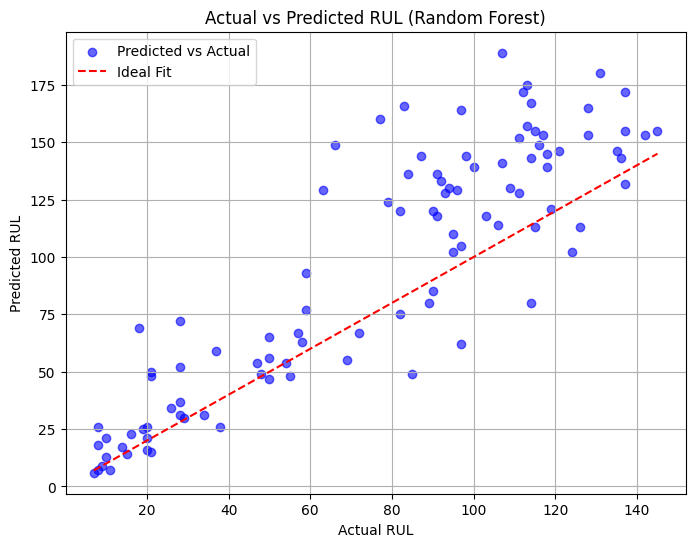


Predicted Class Distribution (Counts):
Predicted Classification
Healthy     72
Warning     24
Critical     4

Actual Class Distribution (Counts):
Actual Classification
Healthy     67
Warning     28
Critical     5
Results with classifications saved to 'rf_fd001_predictions_with_classifications.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Load FD001 dataset
print("Loading FD001 dataset...")
train_data = pd.read_csv('/content/train_FD001.txt', sep="\s+", header=None)
test_data = pd.read_csv('/content/test_FD001.txt', sep="\s+", header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Add RUL column to train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Drop unnecessary columns based on correlation analysis
print("Dropping correlated features...")
drop_columns = ['Sensor1', 'Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Prepare training and testing data
print("Preparing data...")
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Ensure feature consistency between train and test sets
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Save the trained model
joblib.dump(rf_model, 'rf_model_fd001.pkl')
joblib.dump(scaler, 'scaler_fd001.pkl')
joblib.dump(features.tolist(), 'features_fd001.pkl')

# Make predictions
print("Making predictions...")
y_pred = rf_model.predict(X_test_scaled)
y_pred_rounded = np.round(y_pred)  # Round predictions to whole numbers

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
r2 = r2_score(y_test, y_pred_rounded)

print(f"Random Forest Test RMSE: {rmse}")
print(f"Random Forest Test R^2: {r2}")

# Visualize Results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rounded, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (Random Forest)')
plt.legend()
plt.grid()
plt.show()

# Save predictions to DataFrame
results_df = pd.DataFrame({
    'Engine ID': test_data['Engine ID'].unique(),
    'Predicted RUL': y_pred_rounded,
    'Actual RUL': y_test
})

# Define RUL Categories
def classify_rul(rul):
    if rul < 10:
        return "Critical"
    elif 10 <= rul <= 50:
        return "Warning"
    else:
        return "Healthy"

# Add Classifications
results_df['Predicted Classification'] = results_df['Predicted RUL'].apply(classify_rul)
results_df['Actual Classification'] = results_df['Actual RUL'].apply(classify_rul)

# Display Percentage Distribution of Classes
predicted_class_distribution = results_df['Predicted Classification'].value_counts()
actual_class_distribution = results_df['Actual Classification'].value_counts()

print("\nPredicted Class Distribution (Counts):")
print(predicted_class_distribution.to_string())
print("\nActual Class Distribution (Counts):")
print(actual_class_distribution.to_string())

# Save Results with Classifications
results_df.to_csv('rf_fd001_predictions_with_classifications.csv', index=False)
print("Results with classifications saved to 'rf_fd001_predictions_with_classifications.csv'.")


Loading FD001 dataset...
Calculating RUL...
Performing feature engineering...
Preparing data...
Scaling features...
Training XGBoost model...
Making predictions...
XGBoost Test RMSE: 31.722231951740092
XGBoost Test R^2: 0.417269229888916


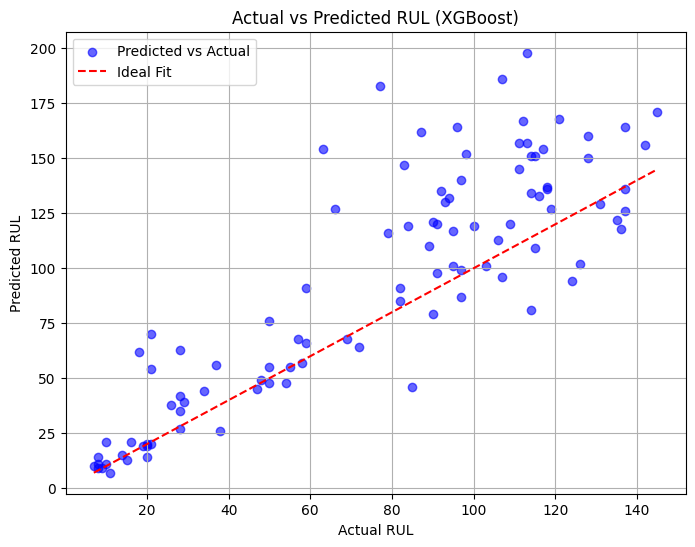


Predicted Class Distribution:
Predicted Classification
Healthy     72
Warning     25
Critical     3
Name: count, dtype: int64

Actual Class Distribution:
Actual Classification
Healthy     67
Warning     28
Critical     5
Name: count, dtype: int64
Results with classifications saved to 'xgb_fd001_predictions_with_classifications.csv'.
Results saved to 'xgb_fd001_predictions.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# Load FD001 dataset
print("Loading FD001 dataset...")
train_data = pd.read_csv('/content/train_FD001.txt', sep="\s+", header=None)
test_data = pd.read_csv('/content/test_FD001.txt', sep="\s+", header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Add RUL column to train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Feature Engineering: Adding rolling statistics
print("Performing feature engineering...")
for dataset in [train_data, test_data]:
    for sensor in ['Sensor3', 'Sensor4', 'Sensor9', 'Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby('Engine ID')[sensor] \
                                                  .rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby('Engine ID')[sensor] \
                                                 .rolling(window=5, min_periods=1).std().reset_index(level=0, drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby('Engine ID')[sensor].diff()

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor1', 'Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Prepare training and testing data
print("Preparing data...")
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Ensure feature consistency between train and test sets
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for reproducibility
joblib.dump(scaler, 'scaler_fd001.pkl')

# Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)
xgb_model.fit(X_train_scaled, y_train)

# Save model
joblib.dump(xgb_model, 'xgb_model_fd001.pkl')

# Make predictions
print("Making predictions...")
y_pred = xgb_model.predict(X_test_scaled)
y_pred_rounded = np.round(y_pred)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
r2 = r2_score(y_test, y_pred_rounded)

print(f"XGBoost Test RMSE: {rmse}")
print(f"XGBoost Test R^2: {r2}")

# Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rounded, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Save predictions to CSV
results_df = pd.DataFrame({
    'Engine ID': test_data['Engine ID'].unique(),
    'Predicted RUL': y_pred_rounded,
    'Actual RUL': y_test
})

# Define RUL Categories
def classify_rul(rul):
    if rul < 10:
        return "Critical"
    elif 10 <= rul <= 50:
        return "Warning"
    else:
        return "Healthy"

# Add Classifications to Results DataFrame
results_df['Predicted Classification'] = results_df['Predicted RUL'].apply(classify_rul)
results_df['Actual Classification'] = results_df['Actual RUL'].apply(classify_rul)

# Display Category Counts
predicted_class_distribution = results_df['Predicted Classification'].value_counts()
actual_class_distribution = results_df['Actual Classification'].value_counts()

print("\nPredicted Class Distribution:")
print(predicted_class_distribution)

print("\nActual Class Distribution:")
print(actual_class_distribution)

# Save Results with Classifications to CSV
results_df.to_csv('xgb_fd001_predictions_with_classifications.csv', index=False)
print("Results with classifications saved to 'xgb_fd001_predictions_with_classifications.csv'.")

results_df.to_csv('xgb_fd001_predictions.csv', index=False)
print("Results saved to 'xgb_fd001_predictions.csv'.")


Ensemble model

Loading datasets...
Performing feature engineering...
Calculating RUL...
Scaling features...
Training base models...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4292
[LightGBM] [Info] Number of data points in the train set: 20631, number of used features: 23
[LightGBM] [Info] Start training from score 107.807862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

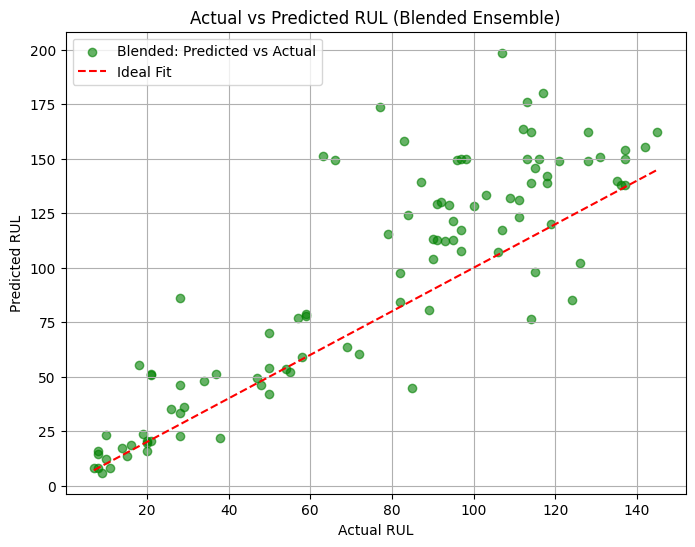


Total Predicted Class Distribution:
Predicted Classification
Healthy     73
Warning     23
Critical     4
Name: count, dtype: int64

Total Actual Class Distribution:
Actual Classification
Healthy     67
Warning     28
Critical     5
Name: count, dtype: int64
Results with classifications saved to 'blended_ensemble_predicted_vs_actual_rul_with_classifications.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

# Load FD001 dataset
print("Loading datasets...")
train_data = pd.read_csv('/content/train_FD001.txt', sep='\s+', header=None)
test_data = pd.read_csv('/content/test_FD001.txt', sep='\s+', header=None)
rul_test = pd.read_csv('/content/RUL_FD001.txt', header=None)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Feature Engineering
print("Performing feature engineering...")
for dataset in [train_data, test_data]:
    for sensor in ['Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).std().reset_index(level=0, drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby('Engine ID')[sensor].diff()

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Add RUL column to train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Prepare training and test data
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Ensure feature consistency between train and test
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and features
joblib.dump(scaler, 'scaler_fd001.pkl')
joblib.dump(features.tolist(), 'features_fd001.pkl')

# Train Base Models
print("Training base models...")

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=400, max_depth=5, learning_rate=0.1, subsample=0.8)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42, n_estimators=400, max_depth=7, learning_rate=0.1, subsample=0.8)
lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)

# Blending: Optimize Weights
print("Optimizing blending weights...")

def objective(weights):
    blended_pred = weights[0] * xgb_pred + weights[1] * rf_pred + weights[2] * lgb_pred
    return np.sqrt(mean_squared_error(y_test, blended_pred))

constraints = [{'type': 'eq', 'fun': lambda weights: 1 - sum(weights)}]
bounds = [(0, 1)] * 3
initial_weights = [1/3, 1/3, 1/3]

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
optimized_weights = result.x
print(f"Optimized Weights: {optimized_weights}")

# Final Blended Prediction
blended_pred = optimized_weights[0] * xgb_pred + optimized_weights[1] * rf_pred + optimized_weights[2] * lgb_pred

# Evaluate the final blended model
blended_rmse = np.sqrt(mean_squared_error(y_test, blended_pred))
blended_r2 = r2_score(y_test, blended_pred)

print(f"Blended Ensemble Test RMSE: {blended_rmse}")
print(f"Blended Ensemble Test R^2: {blended_r2}")

# Visualize Results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, blended_pred, color='green', label='Blended: Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (Blended Ensemble)')
plt.legend()
plt.grid()
plt.show()

# Save predictions to DataFrame
results_df = pd.DataFrame({'Engine ID': test_data['Engine ID'].unique(),
                           'Blended Predicted RUL': np.round(blended_pred),
                           'Actual RUL': y_test})

# Define RUL Categories
def classify_rul(rul):
    if rul < 10:
        return "Critical"
    elif 10 <= rul <= 50:
        return "Warning"
    else:
        return "Healthy"

# Add Classifications
results_df['Predicted Classification'] = results_df['Blended Predicted RUL'].apply(classify_rul)
results_df['Actual Classification'] = results_df['Actual RUL'].apply(classify_rul)

# Display Total Number of Predictions in Each Category
predicted_class_distribution = results_df['Predicted Classification'].value_counts()
actual_class_distribution = results_df['Actual Classification'].value_counts()

print("\nTotal Predicted Class Distribution:")
print(predicted_class_distribution)

print("\nTotal Actual Class Distribution:")
print(actual_class_distribution)


# Save Results with Classifications
results_df.to_csv('blended_ensemble_predicted_vs_actual_rul_with_classifications.csv', index=False)
print("Results with classifications saved to 'blended_ensemble_predicted_vs_actual_rul_with_classifications.csv'.")
